In [1]:
# 导入库
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import os
import torchvision.utils as vutils
import torch.nn.functional as F

In [2]:
MinArea = 150
# 数码管和九宫格的LAB颜色阈值
color_dist = {'five': {'Lower': np.array([int(67 * 255 / 100), -8 + 127, 39 + 127]),
                       'Upper': np.array([int(100 * 255 / 100), 42 + 127, 55 + 127])},
              'nine': {'Lower': np.array([int(52 * 255 / 100), -14 + 127, -18 + 127]),
                       'Upper': np.array([int(98 * 255 / 100), 13 + 127, 28 + 127])}
              }

classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9']

root_dir = "./original_image"
ImageFiveNum = 0
ImageNineNum = 0

In [55]:
# 数码管及九宫格分割函数
def ImageCut(image, flag=0):
    global ImageFiveNum
    # 转换成LAB颜色空间
    imageLab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # 根据阈值进行二值化
    inRange = cv2.inRange(imageLab, color_dist['five']['Lower'], color_dist['five']['Upper'])
    
    # 进行形态学处理
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))
    dilate = cv2.morphologyEx(inRange, cv2.MORPH_CLOSE, kernel)
    
    # 寻找轮廓
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    [H, W, C] = image.shape
    imageROIs = []
    nums = []
    cornerBox = []
    center_x = 0
    center_y = 0
    for contour in contours:
        # 画最小外接矩形
        rectContour = cv2.minAreaRect(contour)
        area = cv2.contourArea(contour)
        
        if area > MinArea:
            cornerPoint = cv2.boxPoints(rectContour)
            x = [cornerPoint[0][0], cornerPoint[1][0], cornerPoint[2][0], cornerPoint[3][0]]
            y = [cornerPoint[0][1], cornerPoint[1][1], cornerPoint[2][1], cornerPoint[3][1]]
            mean_x = sum(x) / 4
            mean_y = sum(y) / 4
            center_x += mean_x
            center_y += mean_y
            nums.append([mean_x, mean_y, x, y, contour])
        
    center_x = center_x / len(nums)
    center_y = center_y / len(nums)
    nums.sort(key=lambda x:x[0])
        
    for num in nums:
        x = num[2]
        y = num[3]
        x_min = int(min(x) - 10) if (int(min(x) - 2) > 0) else 0
        x_max = int(max(x) + 10) if (int(max(x) + 2) < W) else W
        y_min = int(min(y) - 10) if (int(min(y) - 2) > 0) else 0
        y_max = int(max(y) + 10) if (int(max(y) + 2) < H) else H
        
        cornerBox.append([x_min, x_max, y_min, y_max])
        imageROI = image[y_min:y_max, x_min:x_max]
        imageROI = cv2.resize(imageROI, (128, 128))
        ImageFiveNum = ImageFiveNum + 1
        if flag == 1:
            cv2.imwrite(root_dir + '/cut_numeral/' + str(ImageFiveNum)+ '.jpg', imageROI)
        imageROIs.append(imageROI)
        
    imageNineROIs, cornerBigBox, numsNine, imageNineRGB = NineCut(image, center_x, center_y, W, H, flag)
        
    return imageROIs, cornerBox, imageNineROIs, cornerBigBox, numsNine, imageNineRGB

In [56]:
#分割九宫格函数
def NineCut(image, center_x, center_y, W, H, flag=0):
    global ImageNineNum
    
    x_min = int(center_x - 300) if (int(center_x - 300) > 0) else 0
    x_max = int(center_x + 300) if (int(center_x + 300) < W) else W
    y_min = int(center_y + 40) if (int(center_y + 40) > 0) else 0
    y_max = int(center_y + 520) if (int(center_y + 520) < H) else H

    imageNine = image[y_min:y_max, x_min:x_max]
    
    imageNineLab = cv2.cvtColor(imageNine, cv2.COLOR_BGR2LAB)
    imageNineRGB = cv2.cvtColor(imageNine, cv2.COLOR_BGR2RGB)
    imageNineInRange = cv2.inRange(imageNineLab, color_dist['nine']['Lower'], color_dist['nine']['Upper'])
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    imageNineDilate = cv2.morphologyEx(imageNineInRange, cv2.MORPH_CLOSE, kernel)
    contoursNine, hierarchyNine = cv2.findContours(imageNineDilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    centerNine_x = 0
    centerNine_y = 0
    numsNine = []
    for contour in contoursNine:
        rect = cv2.minAreaRect(contour)
        area = cv2.contourArea(contour)
        
        if area > MinArea:
            cornerPoint = cv2.boxPoints(rect)
            x = [cornerPoint[0][0], cornerPoint[1][0], cornerPoint[2][0], cornerPoint[3][0]]
            y = [cornerPoint[0][1], cornerPoint[1][1], cornerPoint[2][1], cornerPoint[3][1]]
#             print(x)
            mean_x = sum(x) / 4
            mean_y = sum(y) / 4
            centerNine_x += mean_x
            centerNine_y += mean_y
            numsNine.append([mean_x, mean_y, x, y, contour])

    # 显示分割后的图片
    centerNine_x /= len(numsNine)
    centerNine_y /= len(numsNine)
    index = np.zeros((3, 3))
    # 进行排序
    # print(numNine)
    for i, numNine in enumerate(numsNine):
        mean_x = numNine[0]
        mean_y = numNine[1]
    
        if mean_x - centerNine_x < -10:
            index_x = 0
        elif mean_x - centerNine_x > 10:
            index_x = 2
        else:
            index_x = 1
        
        if mean_y - centerNine_y < -10:
            index_y = 0
        elif mean_y - centerNine_y > 10:
            index_y = 2
        else:
            index_y = 1
    
        index[index_y][index_x] = i

    [HNine, WNine, CNine] = imageNine.shape
    # 进行切割
    imageNineROIs = []
    cornerBigBox = []
    for i in range(3):
        for j in range(3):
            x = numsNine[int(index[i][j])][2]
            y = numsNine[int(index[i][j])][3]
            xNine_min = int(min(x) - 10) if (int(min(x) - 10 > 0)) else 0
            xNine_max = int(max(x) + 10) if (int(max(x) + 10) < WNine) else WNine
            yNine_min = int(min(y) - 10) if (int(min(y) - 10) > 0) else 0
            yNine_max = int(max(y) + 10) if (int(max(y) + 10) < HNine) else HNine
            
            cornerBigBox.append([x_min + xNine_min, x_min + xNine_max, y_min + yNine_min, y_min + yNine_max])
            imageROI = imageNine[yNine_min:yNine_max, xNine_min:xNine_max]
            imageROI = cv2.resize(imageROI, (128, 128))
            ImageNineNum = ImageNineNum + 1
            if flag == 1:
#                 print(ImageNineNum)
                cv2.imwrite(root_dir + '/cut_big/' + str(ImageNineNum)+ '.jpg', imageROI)
            imageNineROIs.append(imageROI)
    
    return imageNineROIs, cornerBigBox, numsNine, imageNineRGB

In [87]:
# 进行数码管分割，并保存图片

# 对原始数据集进行访问
nameLists = os.listdir(root_dir + '/big')
ImageFiveNum = 0
ImageNineNum = 0
for name in nameLists:
    strName = root_dir + '/big/'+ name
    image = cv2.imread(root_dir + '/big/'+ name)
    ImageCut(image, 1)

In [139]:
# 添加噪声
def sp_noise(noise_img, proportion):
    height, width = noise_img.shape[0], noise_img.shape[1]#获取高度宽度像素值
    num = int(height * width * proportion) #一个准备加入多少噪声小点
    for i in range(num):
        w = random.randint(0, width - 1)
        h = random.randint(0, height - 1)
        if random.randint(0, 1) == 0:
            noise_img[h, w] = 0
        else:
            noise_img[h, w] = 255
    return noise_img

def gaussian_noise(img, mean, sigma):
    # 将图片灰度标准化
    img = img / 255
    # 产生高斯 noise
    noise = np.random.normal(mean, sigma, img.shape)
    # 将噪声和图片叠加
    gaussian_out = img + noise
    # 将超过 1 的置 1，低于 0 的置 0
    gaussian_out = np.clip(gaussian_out, 0, 1)
    # 将图片灰度范围的恢复为 0-255
    gaussian_out = np.uint8(gaussian_out*255)
    # 将噪声范围搞为 0-255
    # noise = np.uint8(noise*255)
    return gaussian_out# 这里也会返回噪声，注意返回值

def random_noise(image, noise_num):
    # cv2.imshow("src", img)
    rows, cols, chn = image.shape
    # 加噪声
    for i in range(noise_num):
        x = np.random.randint(0, rows)#随机生成指定范围的整数
        y = np.random.randint(0, cols)
        image[x-1:x+1, y-1:y+1, :] = 255
    return image

def rotate_image_randomly(image, angle_range=(-10, 10)):  
    # 获取图像尺寸  
    (h, w) = image.shape[:2]  
      
    # 旋转中心为图像中心  
    center = (w // 2, h // 2)  
      
    # 生成随机角度  
    angle = random.uniform(angle_range[0], angle_range[1])  
      
    # 获取旋转矩阵  
    # 注意OpenCV的旋转角度是逆时针的，所以要旋转顺时针角度，需要传入负值  
    M = cv2.getRotationMatrix2D(center, -angle, 1.0)  
      
    # 计算旋转后的图像尺寸  
    cos = np.abs(M[0, 0])  
    sin = np.abs(M[0, 1])  
      
    # 计算新图像的边界  
    nW = int((h * sin) + (w * cos))  
    nH = int((h * cos) + (w * sin))  
  
    # 调整旋转矩阵以考虑平移  
    M[0, 2] += (nW / 2) - center[0]  
    M[1, 2] += (nH / 2) - center[1]  
  
    # 使用仿射变换进行旋转  
    rotated = cv2.warpAffine(image, M, (nW, nH))  
      
    return rotated

data_path = './original_image/train_data_numeral'
path_list = os.listdir(data_path)
# print(path_list)
for i in path_list:
    index_path = data_path+'/'+i
    index_list = os.listdir(index_path)
    for j in index_list:
        image_path = index_path + '/' + j
        img = cv2.imread(image_path)
        
        rot1 = gaussian_noise(img, 0, 0.15)  # 高斯噪声
        rot2 = random_noise(img, 100)
        rot3 = sp_noise(img, 0.025)
        rot4 = rotate_image_randomly(img)

        img1 = cv2.resize(rot1, (128, 128))
        img2 = cv2.resize(rot2, (128, 128))
        img3 = cv2.resize(rot3, (128, 128))
        img4 = cv2.resize(rot4, (128, 128))
        cv2.imwrite(index_path + '/' + j.split('.')[0] + 'gn.jpg', img1)
        cv2.imwrite(index_path + '/' + j.split('.')[0] + 'rn.jpg', img2)
        cv2.imwrite(index_path + '/' + j.split('.')[0] + 'sn.jpg', img3)
        cv2.imwrite(index_path + '/' + j.split('.')[0] + 'ro.jpg', img4)
        print(i + ' have saved more img')



1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
1 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have saved more img
2 have sav

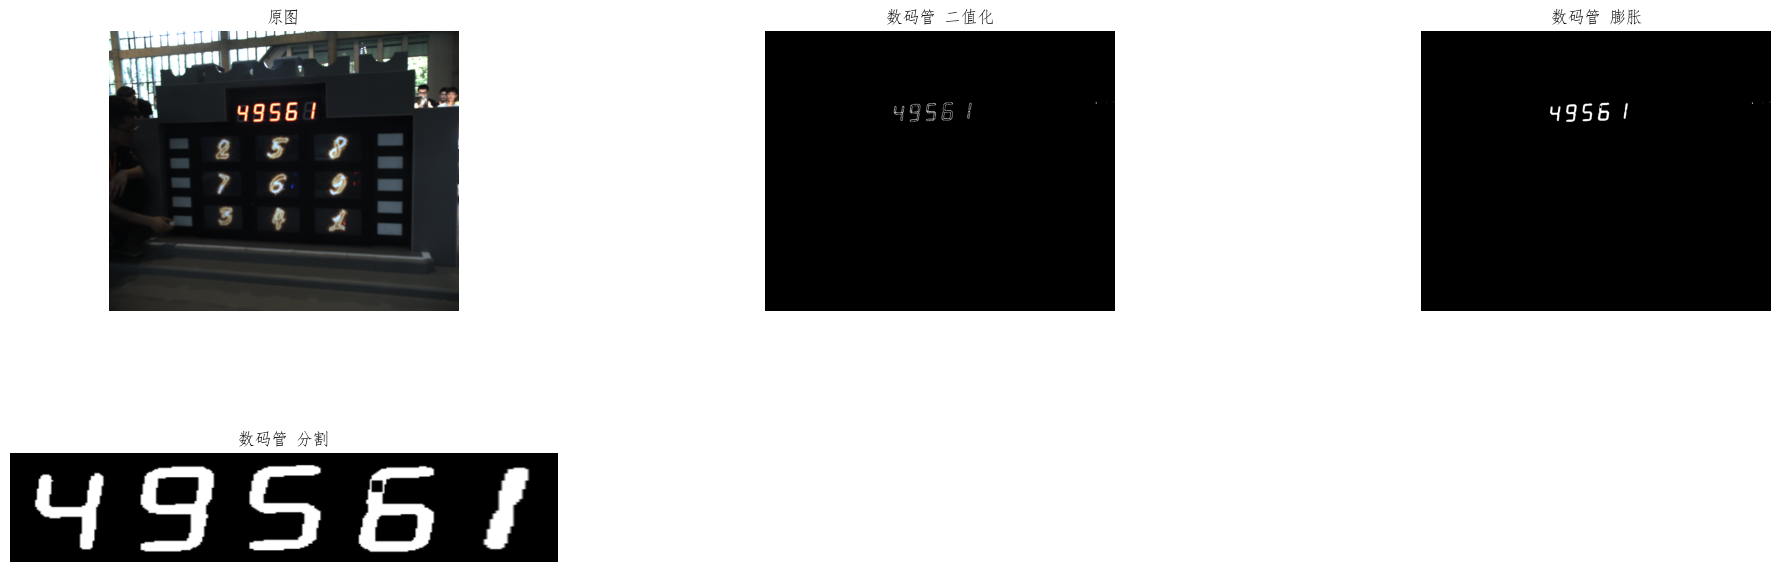

In [68]:
import cv2
import matplotlib.pyplot as plt

# 五位数码管提取
image = cv2.imread('./big/3.bmp')
imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
imageLab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
inRange = cv2.inRange(imageLab, color_dist['five']['Lower'], color_dist['five']['Upper'])

# 进行形态学处理
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))
dilate = cv2.morphologyEx(inRange, cv2.MORPH_CLOSE, kernel)

# 寻找轮廓
contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cntsImage = imageRGB.copy()
cv2.drawContours(cntsImage, contours, -1, (0, 255, 0), 3)

[H, W, C] = image.shape
imageROIs = []
nums = []
center_x = 0
center_y = 0
for contour in contours:
    rectContour = cv2.minAreaRect(contour)
    area = cv2.contourArea(contour)
    
    # 通过面积进行筛选
    if area > MinArea:
        cornerPoint = cv2.boxPoints(rectContour)
        x = [cornerPoint[0][0], cornerPoint[1][0], cornerPoint[2][0], cornerPoint[3][0]]
        y = [cornerPoint[0][1], cornerPoint[1][1], cornerPoint[2][1], cornerPoint[3][1]]
        mean_x = sum(x) / 4
        mean_y = sum(y) / 4
        center_x += mean_x
        center_y += mean_y
        nums.append([mean_x, mean_y, x, y, contour])

center_x = center_x / len(nums)
center_y = center_y / len(nums)
nums.sort(key=lambda x:x[0])
for num in nums:
    x = num[2]
    y = num[3]
    x_min = int(min(x) - 10) if (int(min(x) - 10 > 0)) else 0
    x_max = int(max(x) + 10) if (int(max(x) + 10) < W) else W
    y_min = int(min(y) - 10) if (int(min(y) - 10) > 0) else 0
    y_max = int(max(y) + 10) if (int(max(y) + 10) < H) else H
    
    imageROI = dilate[y_min:y_max, x_min:x_max]
    imageROI = cv2.resize(imageROI, (128, 128))
    imageROIs.append(imageROI)

if len(imageROIs) == 0:
    print("未检测到数码管")
else:
    imageCat = imageROIs[0].copy()
    for i in range(1, len(imageROIs)):
        imageCat = cv2.hconcat([imageCat, imageROIs[i]])

plt.figure(figsize=(24,8))
plt.rcParams['font.sans-serif'] = ['FangSong']
plt.subplot(231), plt.title('原图'), plt.axis('off')
plt.imshow(imageRGB)
plt.subplot(232), plt.title('数码管 二值化'), plt.axis('off')
plt.imshow(inRange, cmap = 'gray')
plt.subplot(233), plt.title('数码管 膨胀'), plt.axis('off')
plt.imshow(dilate, cmap = 'gray')
plt.subplot(234), plt.title('数码管 轮廓'), plt.axis('off')
plt.imshow(cntsImage)
plt.subplot(234), plt.title('数码管 分割'), plt.axis('off')
plt.imshow(imageCat, cmap='gray')
plt.show()

336


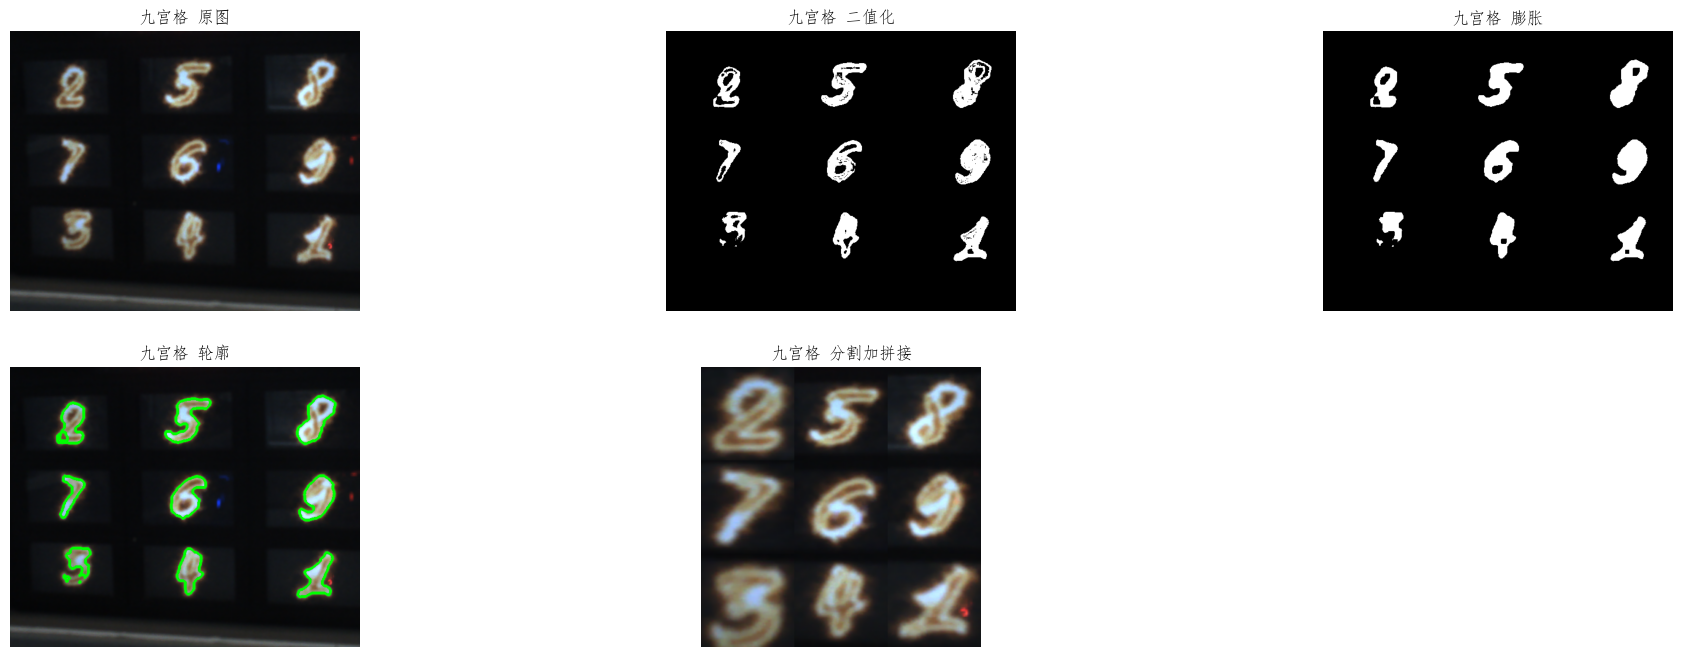

In [69]:
# 九宫格分割流程展示
if len(nums) == 5:
    x_min = int(center_x - 300) if (int(center_x - 300) > 0) else 0
    x_max = int(center_x + 300) if (int(center_x + 300) < W) else W
    y_min = int(center_y + 40) if (int(center_y + 40) > 0) else 0
    y_max = int(center_y + 520) if (int(center_y + 520) < H) else H
    print(y_min)
    imageNine = image[y_min:y_max, x_min:x_max]
    imageNineRGB = cv2.cvtColor(imageNine, cv2.COLOR_BGR2RGB)
    
    imageNineLab = cv2.cvtColor(imageNine, cv2.COLOR_BGR2LAB)
    imageNineInRange = cv2.inRange(imageNineLab, color_dist['nine']['Lower'], color_dist['nine']['Upper'])
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    imageNineDilate = cv2.morphologyEx(imageNineInRange, cv2.MORPH_CLOSE, kernel)
    
    cntsImageNine = imageNineRGB.copy()
    contoursNine, hierarchyNine = cv2.findContours(imageNineDilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(cntsImageNine, contoursNine, -1, (0, 255, 0), 3)
    
    centerNine_x = 0
    centerNine_y = 0
    numsNine = []
    for contour in contoursNine:
        rect = cv2.minAreaRect(contour)
        area = cv2.contourArea(contour)
        
        if area > MinArea:
            cornerPoint = cv2.boxPoints(rect)
            x = [cornerPoint[0][0], cornerPoint[1][0], cornerPoint[2][0], cornerPoint[3][0]]
            y = [cornerPoint[0][1], cornerPoint[1][1], cornerPoint[2][1], cornerPoint[3][1]]
#             print(x)
            mean_x = sum(x) / 4
            mean_y = sum(y) / 4
            centerNine_x += mean_x
            centerNine_y += mean_y
            numsNine.append([mean_x, mean_y, x, y, contour])

# 显示分割后的图片
centerNine_x /= len(numsNine)
centerNine_y /= len(numsNine)
index = np.zeros((3, 3))
# 进行排序
# print(numNine)
for i, numNine in enumerate(numsNine):
    mean_x = numNine[0]
    mean_y = numNine[1]
    
    if mean_x - centerNine_x < -10:
        index_x = 0
    elif mean_x - centerNine_x > 10:
        index_x = 2
    else:
        index_x = 1
        
    if mean_y - centerNine_y < -10:
        index_y = 0
    elif mean_y - centerNine_y > 10:
        index_y = 2
    else:
        index_y = 1
    
    index[index_y][index_x] = i

[HNine, WNine, CNine] = imageNine.shape
# 进行切割
imageNineROIs = []
for i in range(3):
    for j in range(3):
#         print(index[i][j])
        x = numsNine[int(index[i][j])][2]
        y = numsNine[int(index[i][j])][3]
#         print(x)
        x_min = int(min(x) - 10) if (int(min(x) - 10 > 0)) else 0
        x_max = int(max(x) + 10) if (int(max(x) + 10) < WNine) else WNine
        y_min = int(min(y) - 10) if (int(min(y) - 10) > 0) else 0
        y_max = int(max(y) + 10) if (int(max(y) + 10) < HNine) else HNine
    
        imageROI = imageNineRGB[y_min:y_max, x_min:x_max]
#         print(imageROI.shape)
        imageROI = cv2.resize(imageROI, (128, 128))
        imageNineROIs.append(imageROI)
    
# 进行拼接及显示
# 先水平拼接再竖直拼接
imageV1 = cv2.hconcat([imageNineROIs[0], imageNineROIs[1], imageNineROIs[2]])
imageV2 = cv2.hconcat([imageNineROIs[3], imageNineROIs[4], imageNineROIs[5]])
imageV3 = cv2.hconcat([imageNineROIs[6], imageNineROIs[7], imageNineROIs[8]])
imageFinal = cv2.vconcat([imageV1, imageV2, imageV3])

plt.figure(figsize=(24,8))
plt.rcParams['font.sans-serif'] = ['FangSong']
plt.subplot(231), plt.title('九宫格 原图'), plt.axis('off')
plt.imshow(imageNineRGB)
plt.subplot(232), plt.title('九宫格 二值化'), plt.axis('off')
plt.imshow(imageNineInRange, cmap='gray')
plt.subplot(233), plt.title('九宫格 膨胀'), plt.axis('off')
plt.imshow(imageNineDilate, cmap='gray')
plt.subplot(234), plt.title('九宫格 轮廓'), plt.axis('off')
plt.imshow(cntsImageNine)
plt.subplot(235), plt.title('九宫格 分割加拼接'), plt.axis('off')
plt.imshow(imageFinal, cmap='gray')


plt.show()


In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 识别
# 搭建网络框架
# 搭建CNN
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # 第一次卷积操作：3*128*128->64*126*126
        # 第一次最大池化层：64*126*126->64*63*63
        # 第二次卷积操作：64*63*63->64*61*61
        # 第二次最大池化层: 64*61*61->64*30*30
        # 进行全连接层: (64*30*30)*1
        
        # 卷积操作
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        
        # 最大池化层
        # (H-F+2P)/S+1
        # 当ceil_mode=True时，是向上取整
        self.maxpool = nn.MaxPool2d(2, 2)
        
        # 展平，即全连接层
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*30*30, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        
        x = self.flatten(x)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        # x = self.softmax(x)
        
        return x

modelBig = CNN(9).to(device)
modelNumeral = CNN(9).to(device)


In [43]:
# 设置学习率
learning_rate = 1e-3
# 迭代次数
epochs = 30
# 设置优化器
optimizerBig = optim.SGD(modelBig.parameters(), lr=learning_rate)
optimizerNumeral = optim.SGD(modelNumeral.parameters(), lr=learning_rate)
# 设置损失函数
loss = nn.CrossEntropyLoss()

In [66]:
# 对数据进行处理
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

trainBig_dir = "./original_image/train_data_big"
trainNumeral_dir = "./original_image/train_data_numeral"
# dataset = ImageDataset(root_dir=train_dir, transform=transform)
trainBig_dataset = datasets.ImageFolder(root=trainBig_dir, transform=transform)
trainNumeral_dataset = datasets.ImageFolder(root=trainNumeral_dir, transform=transform)

totalBig_samples = len(trainBig_dataset)
totalNumeral_samples = len(trainNumeral_dataset)
testBig_samples = 200
testNumeral_samples = 200
trainBig_samples = totalBig_samples - testBig_samples
trainNumeral_samples = totalNumeral_samples - testNumeral_samples

trainBig_dataset, testBig_dataset = random_split(trainBig_dataset, [trainBig_samples, testBig_samples])
trainNumeral_dataset, testNumeral_dataset = random_split(trainNumeral_dataset, [trainNumeral_samples, testNumeral_samples])

batchBig_size = 32  
batchNumeral_size = 32
trainBig_loader = DataLoader(trainBig_dataset, batch_size=batchBig_size, shuffle=True)
trainNumeral_loader = DataLoader(trainNumeral_dataset, batch_size=batchNumeral_size, shuffle=True)
testBig_loader = DataLoader(testBig_dataset, batch_size=batchBig_size, shuffle=False)
testNumeral_loader = DataLoader(testNumeral_dataset, batch_size=batchNumeral_size, shuffle=False)


In [45]:
# 训练函数
def train(epoch, model, optimizer, train_loader, flag=1, flagtwo=1):
    model.train()
    train_loss = 0
    for data, label in train_loader:
#         print(data.shape)
        data, label = data.to(device), label.to(device)
#         print(label)
        optimizer.zero_grad()
        predict = model(data)
        # label表示的是真实类别的索引，是一个长度为batchsize的张量
#         print(predict)
        fn_loss = loss(predict, label)
        fn_loss.backward()
        optimizer.step()
        if flagtwo:
            train_loss += fn_loss.item()*data.size(0)
        else:
            train_loss = fn_loss.item()*data.size(0)
            return train_loss
        
    train_loss = train_loss / len(train_loader.dataset)
    if flag:
        print('Epoch: {}\tTraining Loss: {:.6f}'.format(epoch, train_loss))
    return train_loss

In [46]:
# 评估函数
def eval(model, test_loader, flag=1):
    model.eval()
    actual_labels = []
    predict_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output= model(data)
            predict = torch.argmax(output, 1)
#             print("Predict: {}\tActual: {}".format(predict, label))
            predict_labels.append(predict.cpu().data.numpy())
            actual_labels.append(label.cpu().data.numpy())
    pred_labels, actual_labels = np.concatenate(predict_labels), np.concatenate(actual_labels)
    accuracy = np.sum(pred_labels == actual_labels) / len(pred_labels)
    if flag:
        print("Accuracy: {:.6f}".format(accuracy))
    return accuracy

In [47]:
LossBig = []
AccuracyBig = []
LossNumeral = []
AccuracyNumeral = []
epochs = 20
ListEpochs = list(range(1,epochs+1))
for epoch in ListEpochs:
    trainBig_loss = train(epoch, modelBig, optimizerBig, trainBig_loader)
    accuracyBig = eval(modelBig, testBig_loader)
    LossBig.append(trainBig_loss)
    AccuracyBig.append(accuracyBig)
    
    trainNumeral_loss = train(epoch, modelNumeral, optimizerNumeral, trainNumeral_loader)
    accuracyNumeral = eval(modelNumeral, testNumeral_loader)
    LossNumeral.append(trainNumeral_loss)
    AccuracyNumeral.append(accuracyNumeral)

Epoch: 1	Training Loss: 2.181092
Accuracy: 0.455000
Epoch: 1	Training Loss: 2.171346
Accuracy: 0.260000
Epoch: 2	Training Loss: 2.137581
Accuracy: 0.400000
Epoch: 2	Training Loss: 2.116825
Accuracy: 0.195000
Epoch: 3	Training Loss: 2.062881
Accuracy: 0.845000
Epoch: 3	Training Loss: 2.060303
Accuracy: 0.205000
Epoch: 4	Training Loss: 1.916148
Accuracy: 0.845000
Epoch: 4	Training Loss: 1.994233
Accuracy: 0.305000
Epoch: 5	Training Loss: 1.623973
Accuracy: 0.990000
Epoch: 5	Training Loss: 1.907978
Accuracy: 0.380000
Epoch: 6	Training Loss: 1.147507
Accuracy: 0.985000
Epoch: 6	Training Loss: 1.795317
Accuracy: 0.605000
Epoch: 7	Training Loss: 0.659986
Accuracy: 0.995000
Epoch: 7	Training Loss: 1.642813
Accuracy: 0.635000
Epoch: 8	Training Loss: 0.363190
Accuracy: 0.995000
Epoch: 8	Training Loss: 1.443134
Accuracy: 0.695000
Epoch: 9	Training Loss: 0.221438
Accuracy: 0.995000
Epoch: 9	Training Loss: 1.213402
Accuracy: 0.760000
Epoch: 10	Training Loss: 0.150201
Accuracy: 0.995000
Epoch: 10	T

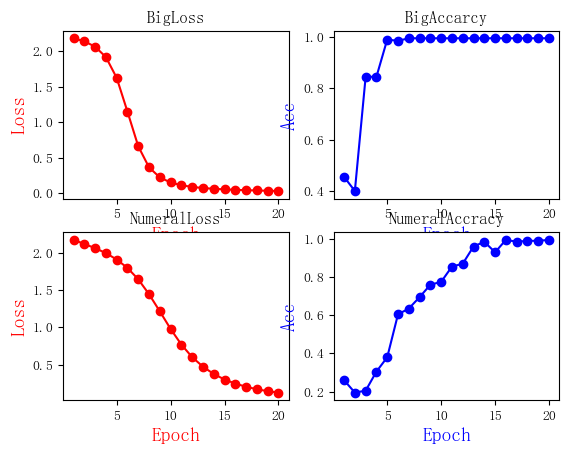

In [48]:
# 画图操作
plt.subplot(221)
plt.plot(ListEpochs, LossBig, color='r', marker='o', linestyle='-')
plt.xlabel('Epoch', fontsize=14, color='r')
plt.ylabel('Loss', fontsize=14, color='r')
plt.title('BigLoss')
plt.subplot(222)
plt.plot(ListEpochs, AccuracyBig, color='b', marker='o', linestyle='-')
plt.xlabel('Epoch', fontsize=14, color='b')
plt.ylabel('Acc', fontsize=14, color='b')
plt.title('BigAccarcy')
plt.subplot(223)
plt.plot(ListEpochs, LossNumeral, color='r', marker='o', linestyle='-')
plt.xlabel('Epoch', fontsize=14, color='r')
plt.ylabel('Loss', fontsize=14, color='r')
plt.title('NumeralLoss')
plt.subplot(224)
plt.plot(ListEpochs, AccuracyNumeral, color='b', marker='o', linestyle='-')
plt.xlabel('Epoch', fontsize=14, color='b')
plt.ylabel('Acc', fontsize=14, color='b')
plt.title('NumeralAccracy')

torch.save(modelBig.state_dict(), "modelBig.model")
torch.save(modelNumeral.state_dict(), "modelNumeral.model")

In [63]:
# 识别函数
def recog(model, imageROI):
        # 对图像进行识别
    recogImage_tensor = torch.tensor(imageROI).float()
    recogImage_tensor = recogImage_tensor.unsqueeze_(0).permute(0, 3, 1, 2).to(device)
    output = model(recogImage_tensor)
    predict = torch.argmax(output, 1)
    predictList = predict.tolist()
    return predictList

model path exists


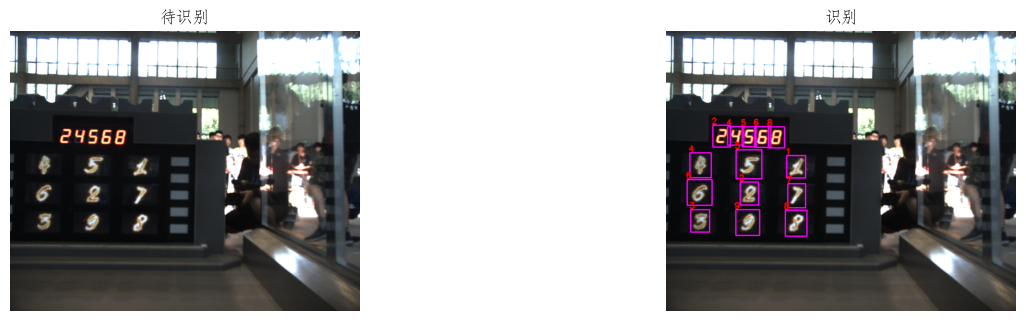

In [70]:
# 加载模型
# 设置权重文件的路径
state_dict_numeral_path = "C:/Users/Whales/图像处理大作业/modelNumeral.model"
state_dict_big_path = "C:/Users/Whales/图像处理大作业/modelBig.model"
#判断路径是否存在
if os.path.exists(state_dict_numeral_path) and os.path.exists(state_dict_big_path):
    # 如果权重文件存在，则把他加载进来
    print("model path exists")
    PredictNumeralModel = CNN(9).to(device)
    PredictBigModel = CNN(9).to(device)
    state_dict_numeral = torch.load(state_dict_numeral_path)
    state_dict_big = torch.load(state_dict_big_path)
    PredictNumeralModel.load_state_dict(state_dict_numeral)
    PredictBigModel.load_state_dict(state_dict_big)
else:
    print("model path dosen exist")


# 进行完整图片的识别
detectImage = cv2.imread("./original_image/big/40.bmp")
detectImageRGB = cv2.cvtColor(detectImage, cv2.COLOR_BGR2RGB)
ImageNineNum = 0
ImageFiveNum = 0
imageROIs, cornerBox, imageNineROIs, cornerBigBox, numsNine, imageNineRGB = ImageCut(detectImage, 0)

polishedImage = detectImageRGB.copy()
for i in range(len(cornerBox)):

    x_min = int(cornerBox[i][0])
    x_max = int(cornerBox[i][1])
    y_min = int(cornerBox[i][2])
    y_max = int(cornerBox[i][3])

    cv2.rectangle(polishedImage, (x_min, y_min), (x_max, y_max), (255, 0, 255), 3)
    
    predictList = recog(PredictNumeralModel, imageROIs[i])
    cv2.putText(polishedImage, classes[predictList[0]],
                        (int(x_min-5), int(y_min-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

for i in range(len(cornerBigBox)):
    
    x_min = int(cornerBigBox[i][0])
    x_max = int(cornerBigBox[i][1])
    y_min = int(cornerBigBox[i][2])
    y_max = int(cornerBigBox[i][3])

    cv2.rectangle(polishedImage, (x_min, y_min), (x_max, y_max), (255, 0, 255), 3)
        # 对图像进行识别

    predictList = recog(PredictBigModel, imageNineROIs[i])
    cv2.putText(polishedImage, classes[predictList[0]],
                        (int(x_min-5), int(y_min-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
    
plt.figure(figsize=(24,8))
plt.rcParams['font.sans-serif'] = ['FangSong']
plt.subplot(231), plt.title('待识别'), plt.axis('off')
plt.imshow(detectImageRGB)
plt.subplot(232), plt.title('识别'), plt.axis('off')
plt.imshow(polishedImage)
plt.show()